# Predicting Diabetes - Classifcation Task
Macro F1 score is the evaluation metric

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("diabetes_train.csv")

## Get to know the data

In [3]:
df_train.head(5)

,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes
0,358,13,129,0,30,0,39.9,0.569,44,1
1,74,4,129,86,20,270,35.1,0.231,23,0
2,353,3,61,82,28,0,34.4,0.243,46,0
3,498,2,81,72,15,76,30.1,0.547,25,0
4,146,0,102,75,23,0,0.0,0.572,21,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  576 non-null    int64  
 1   num_times_pregnant  576 non-null    int64  
 2   plasma_glucose      576 non-null    int64  
 3   DBP                 576 non-null    int64  
 4   triceps_skin        576 non-null    int64  
 5   serum_insulin       576 non-null    int64  
 6   BMI                 576 non-null    float64
 7   pedigree            576 non-null    float64
 8   age                 576 non-null    int64  
 9   diabetes            576 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 45.1 KB


## Split Data

In [5]:
from sklearn.model_selection import train_test_split

Id_col = 'Id'
target_col = 'diabetes'

X = df_train.drop([Id_col, target_col], axis=1)
y = df_train[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

array([[<AxesSubplot:title={'center':'num_times_pregnant'}>,
        <AxesSubplot:title={'center':'plasma_glucose'}>,
        <AxesSubplot:title={'center':'DBP'}>],
       [<AxesSubplot:title={'center':'triceps_skin'}>,
        <AxesSubplot:title={'center':'serum_insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'pedigree'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

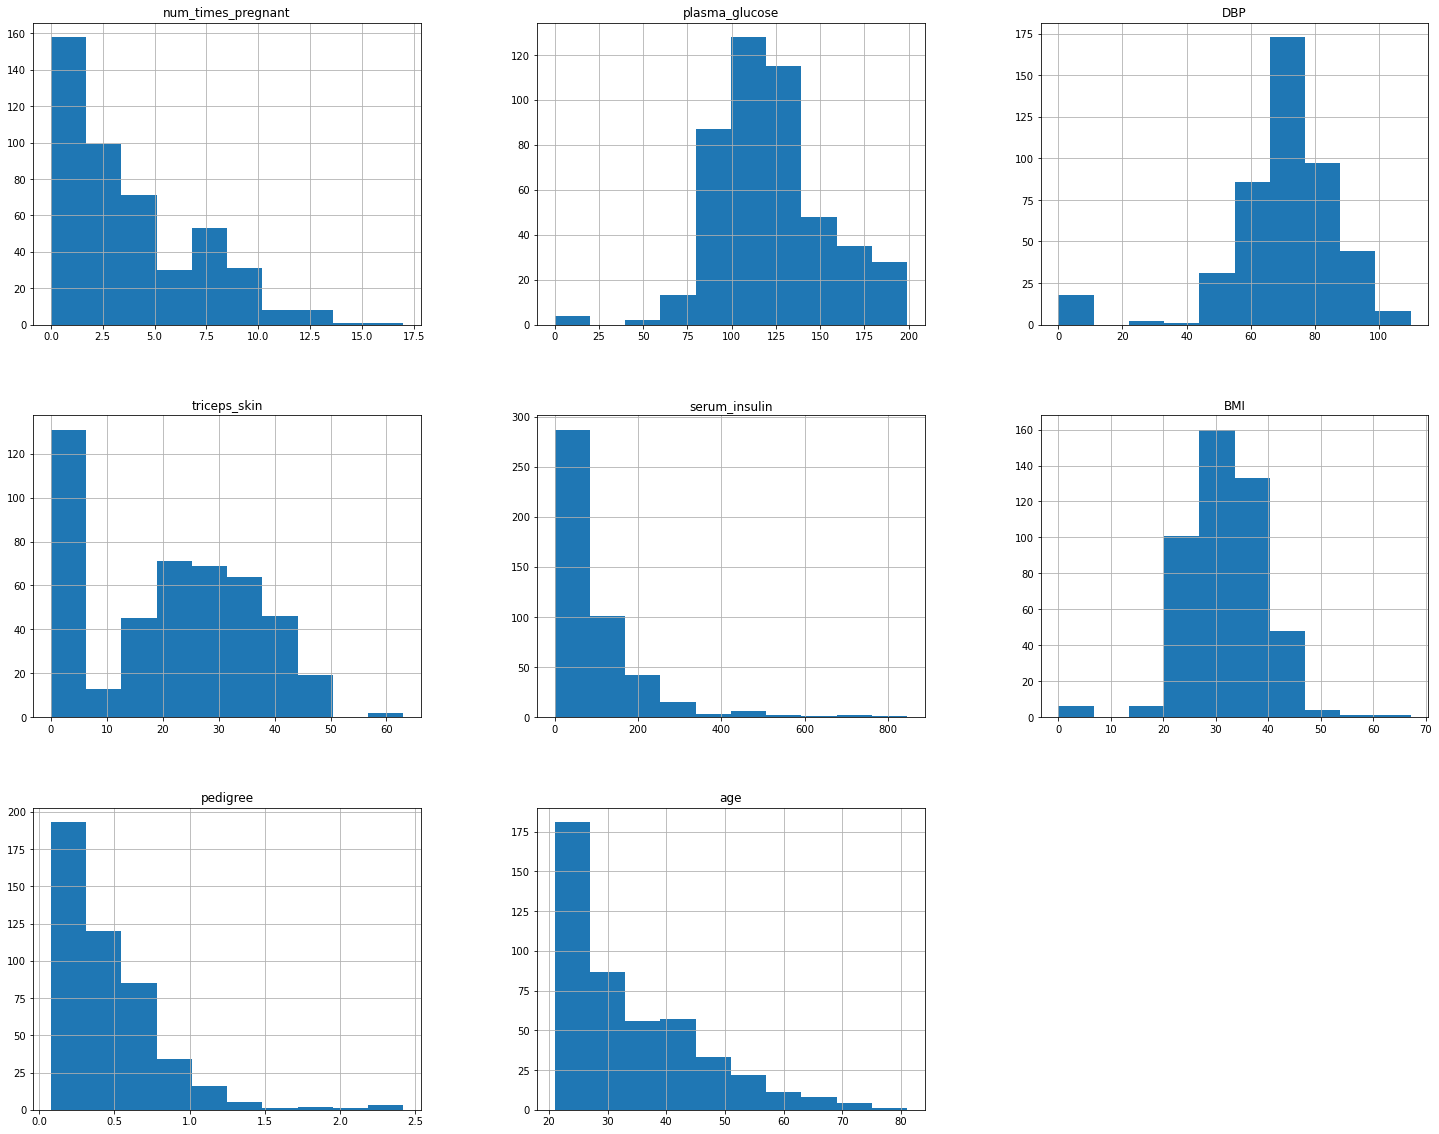

In [6]:
X_train.hist(figsize=(25, 20))

## Build AutoML Model
Use AutoML to get a sense of which algorithm works best

In [ ]:
from flaml import AutoML
automl_clf = AutoML()
automl_clf.fit(X_train, y_train, task="classification", time_budget=500, verbose=3)

In [8]:
y_pred = automl_clf.predict(X_test)

In [9]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87        81
           1       0.78      0.51      0.62        35

    accuracy                           0.81       116
   macro avg       0.80      0.73      0.75       116
weighted avg       0.81      0.81      0.80       116



## Apply Feature Engineering
- SimpleImputer for inadmissible value of 0 for plasma_glucose, DBP, triceps_skin, BMI features
- StandardScaler

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier # XGBoost was the best performing algorithm found by AutoML

In [11]:
# Make column transformer with simple imputer
simple_imputer_transformer = ColumnTransformer(transformers=[('simpleimputer', SimpleImputer(missing_values=0),
                                              ['plasma_glucose', 'DBP', 'triceps_skin', 'BMI'])])

In [12]:
# Create pipeline with feature engineering and classifier
simple_imputer_pipe = make_pipeline(simple_imputer_transformer,
                    StandardScaler(),
                    XGBClassifier(objective='binary:hinge', seed=42))

## Pipeline Hyperparameter Tuning

SimpleImputer hyperparameter to tune:
- strategy

Hyperparameters to tune for XGBoost:
- booster
- learning_rate
- max_depth
- min_child_weight
- subsample
- tree_method
- n_estimators

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

parameter_grid = {'columntransformer__simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
                  'xgbclassifier__booster': ['gbtree', 'gblinear', 'dart'],
                  'xgbclassifier__learning_rate': uniform(0, 1),
                  'xgbclassifier__max_depth': randint(3, 10),
                  'xgbclassifier__min_child_weight': uniform(0, 100),
                  'xgbclassifier__subsample': uniform(0.5, 1),
                  'xgbclassifier__tree_method': ['auto', 'exact', 'approx', 'hist'],
                  'xgbclassifier__n_estimators': randint(50, 300)}

xgbclf_rs = RandomizedSearchCV(simple_imputer_pipe, param_distributions=parameter_grid, n_iter=1000, scoring='f1_macro', 
                           cv=5, n_jobs=-1, return_train_score=True)

In [14]:
# Fit to training data
xgbclf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('simpleimputer',
                                                                               SimpleImputer(missing_values=0),
                                                                               ['plasma_glucose',
                                                                                'DBP',
                                                                                'triceps_skin',
                                                                                'BMI'])])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                          

In [23]:
# Print the hyperparameters, score, standard deviation, and standard deviation range of the
# best performing model from RandomizedSearchCV

avg = xgbclf_rs.best_score_
stddev = xgbclf_rs.cv_results_['std_test_score'][xgbclf_rs.best_index_]

print(f"Best Hyperparameters: {xgbclf_rs.best_params_}\n")
print(f"Best Mean Score: {avg:.4f}")
print(f"Best Mean Std. Dev.: {stddev:.4f}")
print(f"+/-2 std. dev. range within mean: ({avg - 2*stddev:.4f}, {avg + 2*stddev:.4f})")

Best Hyperparameters: {'columntransformer__simpleimputer__strategy': 'mean', 'xgbclassifier__booster': 'gblinear', 'xgbclassifier__learning_rate': 0.04042782338781714, 'xgbclassifier__max_depth': 9, 'xgbclassifier__min_child_weight': 46.750402383986234, 'xgbclassifier__n_estimators': 88, 'xgbclassifier__subsample': 0.8267634626751578, 'xgbclassifier__tree_method': 'approx'}

Best Mean Score: 0.7456
Best Mean Std. Dev.: 0.0431
+/-2 std. dev. range within mean: (0.6594, 0.8317)


## Evaluate on Test Data

In [16]:
# Deploy model on X_test
y_pred = xgbclf_rs.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        81
           1       0.70      0.60      0.65        35

    accuracy                           0.80       116
   macro avg       0.77      0.74      0.75       116
weighted avg       0.80      0.80      0.80       116



## Impute Data with KNN Imputer

In [17]:
# Make column transformer with KNN imputer
knn_imputer_transformer = ColumnTransformer(transformers=[
                            ('stdscaler', StandardScaler(), list(X_train.columns)),
                            ('knnimputer', KNNImputer(missing_values=0), ['plasma_glucose', 'DBP', 'triceps_skin', 'BMI'])
                            ])

In [18]:
# Create pipeline with feature engineering and classifier
knn_imputer_pipe = make_pipeline(knn_imputer_transformer,
                    StandardScaler(),
                    XGBClassifier(objective='binary:hinge', seed=42))

In [24]:
parameter_grid = {'xgbclassifier__booster': ['gbtree', 'gblinear', 'dart'],
                  'xgbclassifier__learning_rate': uniform(0, 1),
                  'xgbclassifier__max_depth': randint(3, 10),
                  'xgbclassifier__min_child_weight': uniform(0, 100),
                  'xgbclassifier__subsample': uniform(0.5, 1),
                  'xgbclassifier__tree_method': ['auto', 'exact', 'approx', 'hist'],
                  'xgbclassifier__n_estimators': randint(50, 300)}

knn_xgbclf_rs = RandomizedSearchCV(knn_imputer_pipe, param_distributions=parameter_grid, n_iter=1000, scoring='f1_macro', 
                           cv=5, n_jobs=-1, return_train_score=True)

In [25]:
# Fit to training data
knn_xgbclf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('stdscaler',
                                                                               StandardScaler(),
                                                                               ['num_times_pregnant',
                                                                                'plasma_glucose',
                                                                                'DBP',
                                                                                'triceps_skin',
                                                                                'serum_insulin',
                                                                                'BMI',
                                                                                'pedigree',
                                                            

In [26]:
# Print the hyperparameters, score, standard deviation, and standard deviation range of the
# best performing model from RandomizedSearchCV

avg = knn_xgbclf_rs.best_score_
stddev = knn_xgbclf_rs.cv_results_['std_test_score'][knn_xgbclf_rs.best_index_]

print(f"Best Hyperparameters: {knn_xgbclf_rs.best_params_}\n")
print(f"Best Mean Score: {avg:.4f}")
print(f"Best Mean Std. Dev.: {stddev:.4f}")
print(f"+/-2 std. dev. range within mean: ({avg - 2*stddev:.4f}, {avg + 2*stddev:.4f})")

Best Hyperparameters: {'xgbclassifier__booster': 'gblinear', 'xgbclassifier__learning_rate': 0.7608287021115674, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 56.0691613629561, 'xgbclassifier__n_estimators': 197, 'xgbclassifier__subsample': 1.3358643547341298, 'xgbclassifier__tree_method': 'hist'}

Best Mean Score: 0.7453
Best Mean Std. Dev.: 0.0534
+/-2 std. dev. range within mean: (0.6385, 0.8521)


## Evaluate on Test Data

In [27]:
# Deploy model on X_test
y_pred = knn_xgbclf_rs.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        81
           1       0.81      0.63      0.71        35

    accuracy                           0.84       116
   macro avg       0.83      0.78      0.80       116
weighted avg       0.84      0.84      0.84       116



## Hyperparameter Tuning using HyperOpt

In [28]:
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe

# Domain space
space={'strategy': hp.choice('strategy', ['mean', 'median', 'most_frequent']),
        'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
        'learning_rate': hp.loguniform ('learning_rate', np.log(0.01), np.log(1)),
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'tree_method': hp.choice('tree_method', ['auto', 'exact', 'approx', 'hist'])}

In [29]:
from sklearn.model_selection import cross_val_score

# Define objective function
def objective_function(space):
    imputer = ColumnTransformer(transformers=[('imputer', SimpleImputer(missing_values=0, strategy=space['strategy']),
                                              ['plasma_glucose', 'DBP', 'triceps_skin', 'BMI'])])
    
    xgb_clf = XGBClassifier(objective='binary:hinge', booster=space['booster'], learning_rate=space['learning_rate'], 
                            max_depth=int(space['max_depth']), gamma=space['gamma'], reg_alpha=int(space['reg_alpha']),
                            reg_lambda=space['reg_lambda'], colsample_bytree=space['colsample_bytree'], 
                            min_child_weight=int(space['min_child_weight']), subsample=space['subsample'], 
                            tree_method=space['tree_method'], n_estimators=200, seed=42)
    
    pipe = make_pipeline(imputer,
                         StandardScaler(),
                         xgb_clf)
    
    f1_score = cross_val_score(pipe, X_train, y_train, scoring = 'f1_macro', cv=5).mean()
    
    return {'loss': -f1_score, 'status': STATUS_OK, 'Trained_Model': xgb_clf}

In [30]:
# Optimization algorithm
trials = Trials()

best_params = fmin(fn=objective_function,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=300,
                   trials=trials)

100%|█████████████████████████████████████████████| 300/300 [01:53<00:00,  2.64trial/s, best loss: -0.7146438627105673]


In [31]:
def getBestModel(trials):
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_index = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_index]
    
    return best_trial_obj['result']['Trained_Model']

In [32]:
print(best_params)

{'booster': 0, 'colsample_bytree': 0.859816355523672, 'gamma': 1.3735458195938568, 'learning_rate': 0.030828919774011383, 'max_depth': 4.0, 'min_child_weight': 2.0, 'reg_alpha': 41.0, 'reg_lambda': 0.951478415188381, 'strategy': 2, 'subsample': 0.7460819542843993, 'tree_method': 0}


In [33]:
best_hyperopt_model = getBestModel(trials)
best_hyperopt_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.859816355523672,
              gamma=1.3735458195938568, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.030828919774011383,
              max_delta_step=0, max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, objective='binary:hinge', random_state=42,
              reg_alpha=41, reg_lambda=0.951478415188381, scale_pos_weight=None,
              seed=42, subsample=0.7460819542843993, tree_method='auto',
              validate_parameters=1, verbosity=None)

In [34]:
# Deploy model on X_test
y_pred = best_hyperopt_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        81
           1       0.63      0.63      0.63        35

    accuracy                           0.78       116
   macro avg       0.73      0.73      0.73       116
weighted avg       0.78      0.78      0.78       116

